# ADMIXTURE

## General Settings

In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM

% run datasets_settings.py
# ^ Will take another ~20s

! echo; wc -l /home/juan/tesina/dataset_dumps/*.samples

[15:15:10] 'panels' dict
[15:15:10] 'galanter', 'present', 'missing' dataframes
[15:15:10] 'panel_labels'
[15:15:10] 'panel_names' dict
[15:15:10] 'panel_rsIDs' dict
[15:15:10] 'genome' dataframe
[15:15:22] 'lat' dataframe
[15:15:43] 'control_genotypes' huge datagrame
[15:15:43] 'control_rsIDs' dict to filter it ^
[15:15:43] 'cp_factors' list
[15:15:43] 'control_labels'
[15:15:43] 'control_names' dict
[15:15:43] 'df_1000G_samples'
[15:15:43] 'df_1000G_SNPs'
[15:15:43] 'df_1000G_genotypes'
[15:15:43] 'df_1000G_populations'
[15:15:44] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/settings/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[15:15:44] 'mafs' dataframe
[15:15:44] 'dataset_names'
[15:15:44] 'dataset_populations'
[15:15:44] 'dataset_samples' created and written to files

  346 /home/juan/tesina/dataset_dumps/L.samples
  544 /home/juan/tesina/dataset_dumps/LE.samples
  751 /home/juan/tesina/dataset_dumps/LEA.samples
  959 /home/juan/tesina/dataset_dumps/LEAC.samples
 1062 /home/juan/tesina/dataset_dumps/LEACI.samples
 3662 total


/home/juan/miniconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


* En `./dataset_dumps/` están los archivos `*.samples` con los sample IDs de 1000 Genomas para cada dataset (`L`, `LE`, `LEA` ...).
* En el mismo directorio copié los bfiles (`.bed`, `.bim` ...) de PLINK de cada panel (GALs y CPs).
* Ahí mismo corrí `./1_create_datasets_run_admixture.sh <nombre-de-panel> <nombre-de-panel-2> ..`
* -> Se crean automáticamente directorios por cada combineta de dataset + panel con los archivos `*.P`
* antes corrí `./0_bring_the_panel_bedfiles.sh` y luego `3_generate` ...

## CV Errors

### Plot the CV errors per dataset / per panel

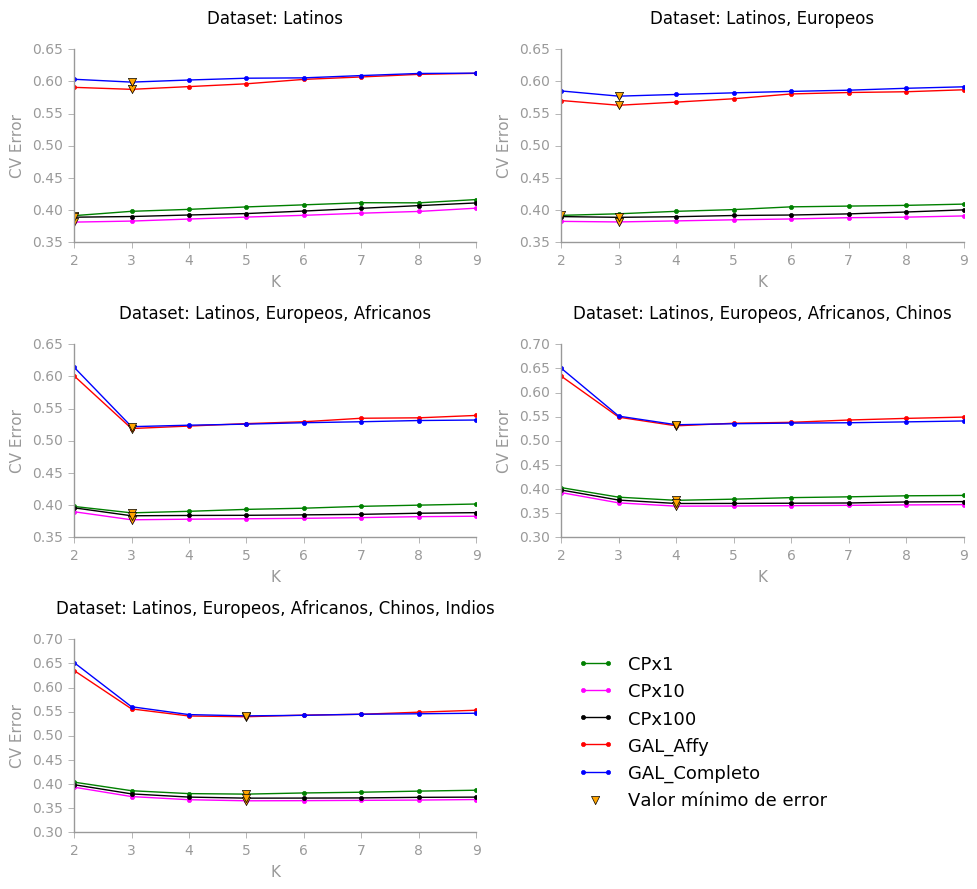

In [4]:
from plotters.admixture_cv_errors import AdmixtureCVErrors

admixture_cv_errors = AdmixtureCVErrors()
cv_errors = admixture_cv_errors.read_cv_errors()
admixture_cv_errors.plot()

## Ancestry ratios per population (mean) and per individual sample

In [ ]:
%%time
# 11s to run this cell if only_optimal_Ks=False

from admixture.results import AdmixtureResults

admix_results = AdmixtureResults()
ancestries_df = admix_results.read_ancestry_files(only_optimal_Ks=False)

In [ ]:
%%time

import seaborn as sns
from plotters.admixture_ancestries import AdmixtureAncestries

sns.set_context("talk")
sns.set_style("white")

admix_plotter = AdmixtureAncestries()

# Rerun this line in case you wanna replot population ancestries means:
admix_plotter.plot_all(ancestries_df)

/home/juan/repos/tesina/plotters/admixture_ancestries.py:61: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_lite = ancestries_df.loc[dataset_label, K, panel_label]
/home/juan/repos/tesina/plotters/admixture_ancestries.py:22: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_lite = ancestries_df.loc[dataset_label, K, panel_label].dropna(axis=1)


In [ ]:
from IPython.display import Image
from os.path import join

panel, dataset, K = "CPx100", "LEACI", 9
filedir = "/home/juan/tesina/charts/ADMIXTURE/"
filename = "{0}__{1}/{1}__{0}__{2}".format(panel, dataset, K)

Image(join(filedir, filename + "__means.png"))

In [ ]:
Image(join(filedir, filename + "__samples.png"))